In [1]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import time
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import pyplot as plt
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# Definir transformações e DataLoader
class DataLoaderSetup:
    def __init__(self, dataset_path, image_size=224, batch_size=32):
        self.dataset_path = dataset_path
        self.image_size = image_size
        self.batch_size = batch_size

    def get_transforms(self):
        transformacoes_de_imagens = {
            'treino': transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(self.image_size, scale=(0.8, 1.0)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'validacao': transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.CenterCrop(self.image_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        return transformacoes_de_imagens

    def load_data(self):
        transformacoes = self.get_transforms()
        pasta_treino = os.path.join(self.dataset_path, 'treino')
        pasta_validacao = os.path.join(self.dataset_path, 'validacao')

        data = {
            'treino': datasets.ImageFolder(root=pasta_treino, transform=transformacoes['treino']),
            'validacao': datasets.ImageFolder(root=pasta_validacao, transform=transformacoes['validacao'])
        }
        return data

    def get_data_loaders(self):
        data = self.load_data()
        data_loader_treino = DataLoader(data['treino'], batch_size=self.batch_size, shuffle=True)
        data_loader_validacao = DataLoader(data['validacao'], batch_size=self.batch_size, shuffle=True)
        return data_loader_treino, data_loader_validacao, len(data['treino']), len(data['validacao']), len(data['treino'].classes)

# Classe para o modelo
class CustomResNet50:
    def __init__(self, num_classes):
        self.model = models.resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False  # Congelar as camadas
        for param in self.model.layer4.parameters():  # Descongelar o bloco "layer4"
            param.requires_grad = True

        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def get_model(self):
        return self.model

class Trainer:
    def __init__(self, model, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience=5, nameModel='model.pt'):
        self.model = model
        self.data_loader_treino = data_loader_treino
        self.data_loader_validacao = data_loader_validacao
        self.num_imagens_treino = num_imagens_treino
        self.num_imagens_validacao = num_imagens_validacao
        self.device = device
        self.funcao_erro = nn.CrossEntropyLoss()
        self.otimizador = optim.Adam(self.model.parameters(), lr=0.0001, weight_decay=1e-4)
        self.scheduler = ReduceLROnPlateau(self.otimizador, mode='min', factor=0.1, patience=3, verbose=True)
        self.patience = patience
        self.nameModel = nameModel

    def treinar_e_validar(self, epocas):
        historico = []
        melhor_acuracia = 0.0
        early_stop_counter = 0

        for epoca in range(epocas):
            inicio_epoca = time.time()
            print(f"\n\nÉpoca: {epoca + 1}/{epocas}")
            erro_treino, acuracia_treino = self.executar_fase('treino')
            erro_validacao, acuracia_validacao, predicoes_validacao, labels_validacao = self.executar_fase('validacao', return_predictions=True)

            fim_epoca = time.time()
            print(f"Época {epoca + 1}/{epocas}, Treino: Erro: {erro_treino:.4f}, Acurácia: {acuracia_treino * 100:.2f}%, "
                  f"Validação: Erro: {erro_validacao:.4f}, Acurácia: {acuracia_validacao * 100:.2f}%, Tempo: {fim_epoca - inicio_epoca:.2f}s")

            historico.append([erro_treino, erro_validacao, acuracia_treino, acuracia_validacao])
            self.scheduler.step(erro_validacao)

            # Early stopping
            if acuracia_validacao > melhor_acuracia:
                melhor_acuracia = acuracia_validacao
                torch.save(self.model.state_dict(), self.nameModel)
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= self.patience:
                print("Parando o treinamento devido ao early stopping.")
                break

        # Calcular métricas finais
        self.calcular_metricas(predicoes_validacao, labels_validacao)
        return historico

    def executar_fase(self, fase, return_predictions=False):
        if fase == 'treino':
            self.model.train()
            data_loader = self.data_loader_treino
            num_imagens = self.num_imagens_treino
        else:
            self.model.eval()
            data_loader = self.data_loader_validacao
            num_imagens = self.num_imagens_validacao

        erro_total = 0.0
        acuracia_total = 0.0
        todas_predicoes = []
        todas_labels = []

        with torch.set_grad_enabled(fase == 'treino'):
            for entradas, labels in data_loader:
                entradas, labels = entradas.to(self.device), labels.to(self.device)

                if fase == 'treino':
                    self.otimizador.zero_grad()

                saidas = self.model(entradas)
                erro = self.funcao_erro(saidas, labels)

                if fase == 'treino':
                    erro.backward()
                    self.otimizador.step()

                erro_total += erro.item() * entradas.size(0)
                _, predicoes = torch.max(saidas, 1)
                acuracia_total += (predicoes == labels).sum().item()

                if return_predictions:
                    todas_predicoes.extend(predicoes.cpu().numpy())
                    todas_labels.extend(labels.cpu().numpy())

        erro_medio = erro_total / num_imagens
        acuracia_media = acuracia_total / num_imagens

        if return_predictions:
            return erro_medio, acuracia_media, todas_predicoes, todas_labels
        else:
            return erro_medio, acuracia_media

    def calcular_metricas(self, predicoes, labels):
        acuracia = accuracy_score(labels, predicoes)
        precisao = precision_score(labels, predicoes, average='weighted')
        recall = recall_score(labels, predicoes, average='weighted')
        f1 = f1_score(labels, predicoes, average='weighted')

        print("\nMétricas de Validação:")
        print(f"Acurácia: {acuracia:.4f}")
        print(f"Precisão: {precisao:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

        print("\nRelatório de Classificação:")
        print(classification_report(labels, predicoes))

        self.plotar_matriz_confusao(labels, predicoes)

    def plotar_matriz_confusao(self, labels, predicoes):
        matriz_confusao = confusion_matrix(labels, predicoes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", xticklabels=self.data_loader_treino.dataset.classes, yticklabels=self.data_loader_treino.dataset.classes)
        plt.ylabel('Classe Verdadeira')
        plt.xlabel('Classe Prevista')
        plt.title('Matriz de Confusão')
        plt.show()


# Dados puros

In [2]:
# dataset_path = '../affectnet/affectnet2/'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Dispositivo utilizado: {device}")

#     # Preparar DataLoaders
# data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
# data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

#     # Carregar o modelo
# modelo = CustomResNet50(num_classes).get_model().to(device)
# nameModel = 'novosModels/affectnet.pt'
# patience = 5
#     # Treinar e validar
# trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience,nameModel)
# historico = trainer.treinar_e_validar(epocas=30)


# Essenciais

In [3]:
# dataset_path = '../affectnet/affectnet_Essenciais/'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Dispositivo utilizado: {device}")

#     # Preparar DataLoaders
# data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
# data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

#     # Carregar o modelo
# modelo = CustomResNet50(num_classes).get_model().to(device)
# nameModel = 'novosModels/affectnet_Essenciais.pt'
#     # Treinar e validar
# patience = 5
# trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience,nameModel)
# historico = trainer.treinar_e_validar(epocas=30)


Landmarks

In [4]:
# dataset_path = '../affectnet/affectnet_landmarks/'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Dispositivo utilizado: {device}")

#     # Preparar DataLoaders
# data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
# data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

#     # Carregar o modelo
# modelo = CustomResNet50(num_classes).get_model().to(device)
# nameModel = 'novosModels/affectnet_landmarks.pt'
#     # Treinar e validar
# patience = 5
# trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience,nameModel)
# historico = trainer.treinar_e_validar(epocas=30)


full connected

In [5]:
# dataset_path = '../affectnet/affectnet_face_connected_landmarks/'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Dispositivo utilizado: {device}")

#     # Preparar DataLoaders
# data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
# data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

#     # Carregar o modelo
# modelo = CustomResNet50(num_classes).get_model().to(device)
# nameModel = 'novosModels/affectnet_face_connected_landmarks.pt'
#     # Treinar e validar
# trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience,nameModel)
# historico = trainer.treinar_e_validar(epocas=30)


# FER

In [6]:
# dataset_path = '../dados1/'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Dispositivo utilizado: {device}")

#     # Preparar DataLoaders
# data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
# data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

#     # Carregar o modelo
# modelo = CustomResNet50(num_classes).get_model().to(device)
# nameModel = 'novosModels/fer_dados1.pt'
# patience = 5
#     # Treinar e validar
# trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience,nameModel)
# historico = trainer.treinar_e_validar(epocas=30)


Essenciais

In [7]:
# dataset_path = '../Essenciais2/'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Dispositivo utilizado: {device}")

#     # Preparar DataLoaders
# data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
# data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

#     # Carregar o modelo
# modelo = CustomResNet50(num_classes).get_model().to(device)
# nameModel = 'novosModels/fer_Essenciais2.pt'
# patience = 5
#     # Treinar e validar
# trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience,nameModel)
# historico = trainer.treinar_e_validar(epocas=30)


In [8]:
# dataset_path = '../full_face_landmarks2/'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Dispositivo utilizado: {device}")

#     # Preparar DataLoaders
# data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
# data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

#     # Carregar o modelo
# modelo = CustomResNet50(num_classes).get_model().to(device)
# nameModel = 'novosModels/fer_full_face_landmarks2.pt'
# patience = 5
#     # Treinar e validar
# trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience,nameModel)
# historico = trainer.treinar_e_validar(epocas=30)


Dispositivo utilizado: cuda:0


c:\Users\Danil\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Danil\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(




Época: 1/30
Época 1/30, Treino: Erro: 1.4055, Acurácia: 45.39%, Validação: Erro: 1.3229, Acurácia: 47.71%, Tempo: 593.13s


Época: 2/30
Época 2/30, Treino: Erro: 1.3269, Acurácia: 48.75%, Validação: Erro: 1.2947, Acurácia: 49.50%, Tempo: 194.99s


Época: 3/30
Época 3/30, Treino: Erro: 1.3019, Acurácia: 49.48%, Validação: Erro: 1.2947, Acurácia: 49.37%, Tempo: 196.34s


Época: 4/30
Época 4/30, Treino: Erro: 1.2876, Acurácia: 50.08%, Validação: Erro: 1.2439, Acurácia: 51.81%, Tempo: 200.30s


Época: 5/30
Época 5/30, Treino: Erro: 1.2843, Acurácia: 50.28%, Validação: Erro: 1.2498, Acurácia: 51.03%, Tempo: 212.09s


Época: 6/30
Época 6/30, Treino: Erro: 1.2736, Acurácia: 50.44%, Validação: Erro: 1.2355, Acurácia: 51.20%, Tempo: 209.83s


Época: 7/30
Época 7/30, Treino: Erro: 1.2738, Acurácia: 50.46%, Validação: Erro: 1.2214, Acurácia: 52.07%, Tempo: 207.33s


Época: 8/30
Época 8/30, Treino: Erro: 1.2714, Acurácia: 50.70%, Validação: Erro: 1.2146, Acurácia: 52.03%, Tempo: 198.27s


Época:

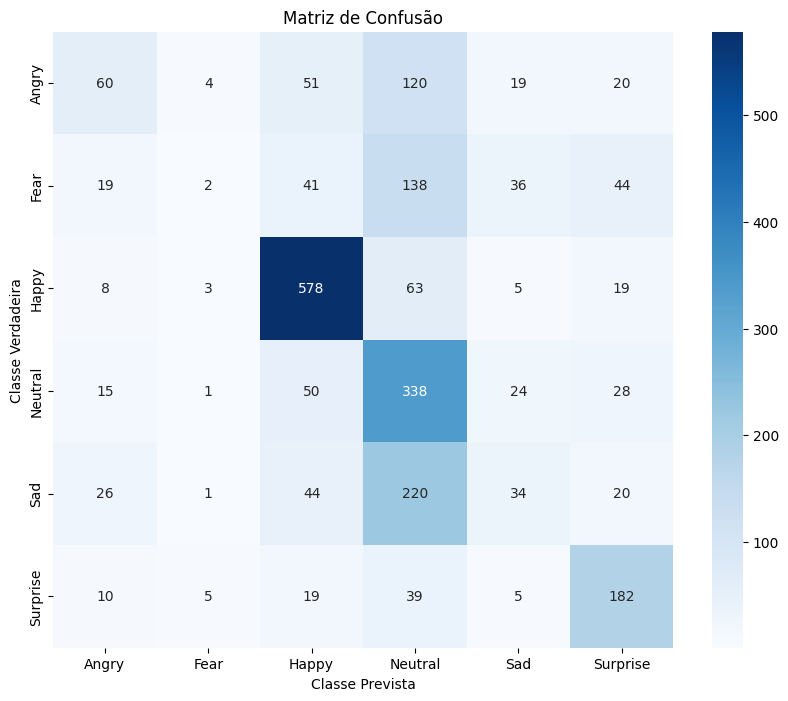

In [9]:
dataset_path = '../full_face_connected_landmarks2/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

    # Preparar DataLoaders
data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

    # Carregar o modelo
modelo = CustomResNet50(num_classes).get_model().to(device)
nameModel = 'novosModels/fer_full_face_connected_landmarks2.pt'
patience = 5
    # Treinar e validar
trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience,nameModel)
historico = trainer.treinar_e_validar(epocas=30)
